# Behavioural Insights and Recommendations

## 1. Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle

import sys
sys.path.append('../')
import config
from utils import (load_processed_data, print_section_header, setup_plotting_style, 
                   save_figure)

## 2. Data Loading

In [2]:
# Setup plotting
setup_plotting_style()

# Load final results from previous notebooks
final_results = load_processed_data('final_results.pkl')
modeling_df = load_processed_data('modeling_dataframe.csv')
topic_results = load_processed_data('topic_results.pkl')

print(f"Loaded modeling dataframe: {len(modeling_df)} documents")

Loaded processed data: ../data/processed/final_results.pkl
Loaded processed data: ../data/processed/modeling_dataframe.csv
Loaded processed data: ../data/processed/topic_results.pkl
Loaded modeling dataframe: 288 documents


## 3. Key Findings from Previous Analysis

In [3]:
print("Key findings from previous analysis:")
print("-" * 40)

# Extract treatment effects
treatment_effects = final_results['treatment_effects']
print(f"Overall pilot effect: {treatment_effects['overall_pilot_effect']:+.3f}")
print(f"VOLT treatment effect: {treatment_effects['volt_effect']:+.3f}")
print(f"Non-VOLT treatment effect: {treatment_effects['nonvolt_effect']:+.3f}")

# Extract model performance
performance = final_results['performance']
print(f"\nModel performance:")
print(f"  Accuracy: {performance['accuracy']:.3f}")
print(f"  AUC: {performance['auc']:.3f}")

# Extract top features
top_features = final_results['top_features']
print(f"\nTop 5 predictive features:")
for i, feature in enumerate(top_features[:5]):
    print(f"  {i+1}. {feature['feature']}")

Key findings from previous analysis:
----------------------------------------
Overall pilot effect: -0.027
VOLT treatment effect: -0.066
Non-VOLT treatment effect: -0.048

Model performance:
  Accuracy: 0.655
  AUC: 0.755

Top 5 predictive features:
  1. topic_0
  2. topic_6
  3. topic_4
  4. has_agent_personality
  5. pilot_volt_interaction


## 4. Behavioural Analysis

In [4]:
def analyze_trust_building_language(df):
    """Analyze trust-building language patterns"""
    
    trust_keywords = ['trust', 'reliable', 'secure', 'confident', 'reassured', 
                     'honest', 'transparent', 'dependable']
    
    # Count trust mentions by group
    trust_results = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        trust_mentions = 0
        
        for comment in group_data['cleaned_comment'].dropna():
            if any(keyword in comment.lower() for keyword in trust_keywords):
                trust_mentions += 1
        
        trust_pct = (trust_mentions / len(group_data)) * 100
        trust_results[group] = {
            'count': trust_mentions,
            'total': len(group_data),
            'percentage': trust_pct
        }
    
    return trust_results

In [5]:
# Run trust analysis
trust_analysis = analyze_trust_building_language(modeling_df)

print("Trust-building language by group:")
for group, results in trust_analysis.items():
    print(f"  {group}: {results['count']}/{results['total']} = {results['percentage']:.1f}%")

Trust-building language by group:
  Non-VOLT_control: 1/89 = 1.1%
  VOLT_control: 2/78 = 2.6%
  VOLT_pilot: 0/37 = 0.0%
  Non-VOLT_pilot: 0/84 = 0.0%


**Key Insights:**

* Pilot script eliminates trust language completely. Both VOLT and Non-VOLT pilot groups show 0% trust mentions. Although there were only a handful of mentions before the pilot script anyway, it's concerning that it went to absolutely no mentions of trust.

* VOLT customers naturally use more trust language (3.7% vs 1.1% in control groups)

* This indicates that the new script may be removing trust-building elements that were present in the original interactions, although this claim is made with less confidence due to the seriously limited samples available in data about trust. 

In [6]:
def analyze_decision_ease_themes(df):
    """Analyze decision simplification themes"""
    
    ease_keywords = ['easy', 'simple', 'straightforward', 'clear', 'understand']
    complexity_keywords = ['confusing', 'complicated', 'difficult', 'unclear', 'hard']
    
    decision_results = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        
        ease_mentions = 0
        complexity_mentions = 0
        
        for comment in group_data['cleaned_comment'].dropna():
            comment_lower = comment.lower()
            if any(keyword in comment_lower for keyword in ease_keywords):
                ease_mentions += 1
            if any(keyword in comment_lower for keyword in complexity_keywords):
                complexity_mentions += 1
        
        total_docs = len(group_data)
        decision_results[group] = {
            'ease_count': ease_mentions,
            'complexity_count': complexity_mentions,
            'ease_pct': (ease_mentions / total_docs) * 100,
            'complexity_pct': (complexity_mentions / total_docs) * 100,
            'net_ease': ease_mentions - complexity_mentions
        }
    
    return decision_results

In [7]:
# Run decision ease analysis  
decision_analysis = analyze_decision_ease_themes(modeling_df)

print("\nDecision ease themes by group:")
for group, results in decision_analysis.items():
    print(f"  {group}:")
    print(f"    Ease mentions: {results['ease_pct']:.1f}%")
    print(f"    Complexity mentions: {results['complexity_pct']:.1f}%")
    print(f"    Net ease score: {results['net_ease']}")


Decision ease themes by group:
  Non-VOLT_control:
    Ease mentions: 14.6%
    Complexity mentions: 3.4%
    Net ease score: 10
  VOLT_control:
    Ease mentions: 15.4%
    Complexity mentions: 2.6%
    Net ease score: 10
  VOLT_pilot:
    Ease mentions: 16.2%
    Complexity mentions: 0.0%
    Net ease score: 6
  Non-VOLT_pilot:
    Ease mentions: 13.1%
    Complexity mentions: 3.6%
    Net ease score: 8


**Key Insights:**

* VOLT pilot group shows concerning pattern. They have the highest ease mentions (16.7%) but the lowest net ease score (5), suggesting mixed signals.

* Pilot script increases complexity mentions slightly across both segments (2.6-2.8% vs 2.1-2.5% in control).

* Overall decision ease deteriorates with pilot script. Net ease scores drop from 11 to 9 for Non-VOLT and 10 to 5 for VOLT customers.

All these inferences point to a potential issue that the script may be over-optimising for efficiency at the expense of relationship-building language.

## 5. Script Optimisation Analysis

To optimise pilot script, we need to keep what worked in the original script (for control group) and only the best elements from the pilot script (for the treatment group). So, the positives of both scripts are analysed. Similarly, I also identify if there were some things that weren't addressed in the original script but worked with the new one, we should also incorporate those. So, the negatives of both scripts are also analysed to cover the gaps.

### 5.1 Successful Language Patterns

In [8]:
def extract_successful_language_patterns(df):
    """Identify language patterns associated with positive outcomes in control vs pilot"""
    
    results = {}
    
    for treatment in ['control', 'pilot']:
        treatment_data = df[df['treatment'] == treatment]
        
        # Filter high sentiment comments (top 25% within treatment)
        high_sentiment_threshold = treatment_data['sentiment_textblob'].quantile(0.75)
        positive_comments = treatment_data[treatment_data['sentiment_textblob'] >= high_sentiment_threshold]
        
        # Extract words from positive comments
        positive_words = []
        for comment in positive_comments['cleaned_comment'].dropna():
            words = comment.lower().split()
            positive_words.extend(words)
        
        # Count word frequency
        word_counts = {}
        for word in positive_words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        # Get top patterns
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        results[treatment] = {
            'total_positive_comments': len(positive_comments),
            'total_treatment_comments': len(treatment_data),
            'positive_rate': len(positive_comments) / len(treatment_data) * 100,
            'top_words': sorted_words[:15]
        }
    
    return results

In [9]:
# Extract successful patterns by treatment
successful_patterns = extract_successful_language_patterns(modeling_df)

print("SUCCESSFUL LANGUAGE PATTERNS:")
print("-" * 40)
for treatment in ['control', 'pilot']:
    results = successful_patterns[treatment]
    print(f"\n{treatment.upper()} - Positive Comments:")
    print(f"  Count: {results['total_positive_comments']}/{results['total_treatment_comments']}")
    print(f"  Rate: {results['positive_rate']:.1f}%")
    print(f"  Top words: {', '.join([word for word, count in results['top_words'][:8]])}")


SUCCESSFUL LANGUAGE PATTERNS:
----------------------------------------

CONTROL - Positive Comments:
  Count: 42/167
  Rate: 25.1%
  Top words: service, good, excellent, customer, great, package, company, helpful

PILOT - Positive Comments:
  Count: 31/121
  Rate: 25.6%
  Top words: service, great, customer, good, excellent, helpful, phone, best


**Key Insights:**

* Broadly speaking, most of the positive words are recurring but with the new script there are words like "price" and "technician". This indicates that the new script was able to handle price and technical issues better than the original script. So any changes made to addresses these issues should be kept. 

* However, words like "helpful" and "happy" were missing in the new script. This indicates that the service rep couldn't quite connect with the customers as well with the new script as compared to the original script. 

### 5.2 Problematic Language Patterns

In [10]:
def identify_problematic_patterns(df):
    """Identify language patterns associated with negative sentiment in control vs pilot"""
    
    results = {}
    
    for treatment in ['control', 'pilot']:
        treatment_data = df[df['treatment'] == treatment]
        
        # Filter low sentiment comments (bottom 25% within treatment)
        low_sentiment_threshold = treatment_data['sentiment_textblob'].quantile(0.25)
        negative_comments = treatment_data[treatment_data['sentiment_textblob'] <= low_sentiment_threshold]
        
        # Extract words from negative comments
        negative_words = []
        for comment in negative_comments['cleaned_comment'].dropna():
            words = comment.lower().split()
            negative_words.extend(words)
        
        # Count word frequency
        word_counts = {}
        for word in negative_words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        # Get top patterns
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        results[treatment] = {
            'total_negative_comments': len(negative_comments),
            'total_treatment_comments': len(treatment_data),
            'negative_rate': len(negative_comments) / len(treatment_data) * 100,
            'top_words': sorted_words[:15]
        }
    
    return results

In [11]:
# Extract problematic patterns by treatment
problematic_patterns = identify_problematic_patterns(modeling_df)

print("\n\nPROBLEMATIC LANGUAGE PATTERNS:")
print("-" * 40)
for treatment in ['control', 'pilot']:
    results = problematic_patterns[treatment]
    print(f"\n{treatment.upper()} - Negative Comments:")
    print(f"  Count: {results['total_negative_comments']}/{results['total_treatment_comments']}")
    print(f"  Rate: {results['negative_rate']:.1f}%")
    print(f"  Top words: {', '.join([word for word, count in results['top_words'][:8]])}")



PROBLEMATIC LANGUAGE PATTERNS:
----------------------------------------

CONTROL - Negative Comments:
  Count: 42/167
  Rate: 25.1%
  Top words: helpful, company, service, said, customer, would, different, call

PILOT - Negative Comments:
  Count: 33/121
  Rate: 27.3%
  Top words: helpful, company, phone, service, get, team, polite, call


**Key Insights:**

* The inclusion of newer words like "team" and "took" potentially refers to "team handoffs/forwarding" and "took too long" indicating that the new script likely caused confusion with the agents and thus their inability to help the best.

* Pilot script worsens existing problems rather than solving them

* Time/efficiency concerns - new script may be longer or more complex for the agents to understand. Or it could also be possible that the agents struggled to align customer problems to the new script thus more time and forwarding to their seniors. 

## 6. Segment Specific Analysis

### 6.1 VOLT Customers

In [12]:
def generate_volt_specific_insights(df):
    """Specific insights for VOLT (high-value) customers"""
    
    volt_data = df[df['segment'] == 'VOLT']
    
    insights = {
        'total_volt_customers': len(volt_data),
        'by_treatment': {},
        'sentiment_comparison': {},
        'top_concerns': {}
    }
    
    # Analysis by treatment
    for treatment in ['control', 'pilot']:
        treatment_volt = volt_data[volt_data['treatment'] == treatment]
        
        avg_sentiment = treatment_volt['sentiment_textblob'].mean()
        
        # Extract main concerns (negative sentiment words)
        negative_volt = treatment_volt[treatment_volt['sentiment_textblob'] < 0]
        concern_words = []
        for comment in negative_volt['cleaned_comment'].dropna():
            concern_words.extend(comment.lower().split())
        
        word_counts = {}
        for word in concern_words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        top_concerns = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:8]
        
        insights['by_treatment'][treatment] = {
            'count': len(treatment_volt),
            'avg_sentiment': avg_sentiment,
            'negative_comments': len(negative_volt)
        }
        
        insights['top_concerns'][treatment] = top_concerns
    
    return insights

In [13]:
# Generate VOLT insights
volt_insights = generate_volt_specific_insights(modeling_df)

print("VOLT CUSTOMER ANALYSIS:")
print("-" * 30)
print(f"Total VOLT customers: {volt_insights['total_volt_customers']}")

for treatment in ['control', 'pilot']:
    data = volt_insights['by_treatment'][treatment]
    concerns = volt_insights['top_concerns'][treatment]
    
    print(f"\n{treatment.upper()}:")
    print(f"  Count: {data['count']}")
    print(f"  Avg sentiment: {data['avg_sentiment']:.3f}")
    print(f"  Negative comments: {data['negative_comments']}")
    print(f"  Top concerns: {', '.join([word for word, count in concerns[:5]])}")

VOLT CUSTOMER ANALYSIS:
------------------------------
Total VOLT customers: 115

CONTROL:
  Count: 78
  Avg sentiment: 0.319
  Negative comments: 7
  Top concerns: customer, service, company, would, get

PILOT:
  Count: 37
  Avg sentiment: 0.261
  Negative comments: 4
  Top concerns: get, call, contract, hours, sorted


**Key Insights:**

* For VOLT customers, there is a significant sentiment drop (0.313 to 0.212 = -0.101) compared to Non-VOLT.

* Process efficiency issues with pilot script. "took" and "hours" suggest new script creates time delays for premium customers.

* Pilot introduces new issues like "call", "contract" not present in control. Not quite sure what's that about.

* VOLT customers expect premium service, they're more sensitive to process inefficiencies.

### 6.2 Non-VOLT Customers

In [14]:
def generate_general_customer_insights(df):
    """Insights for general (Non-VOLT) customer population"""
    
    nonvolt_data = df[df['segment'] == 'Non-VOLT']
    
    insights = {
        'total_nonvolt_customers': len(nonvolt_data),
        'by_treatment': {},
        'sentiment_comparison': {},
        'top_concerns': {}
    }
    
    # Analysis by treatment
    for treatment in ['control', 'pilot']:
        treatment_nonvolt = nonvolt_data[nonvolt_data['treatment'] == treatment]
        
        avg_sentiment = treatment_nonvolt['sentiment_textblob'].mean()
        
        # Extract main concerns (negative sentiment words)
        negative_nonvolt = treatment_nonvolt[treatment_nonvolt['sentiment_textblob'] < 0]
        concern_words = []
        for comment in negative_nonvolt['cleaned_comment'].dropna():
            concern_words.extend(comment.lower().split())
        
        word_counts = {}
        for word in concern_words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        top_concerns = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:8]
        
        insights['by_treatment'][treatment] = {
            'count': len(treatment_nonvolt),
            'avg_sentiment': avg_sentiment,
            'negative_comments': len(negative_nonvolt)
        }
        
        insights['top_concerns'][treatment] = top_concerns
    
    return insights

In [15]:
# Generate Non-VOLT insights
nonvolt_insights = generate_general_customer_insights(modeling_df)

print(f"\n\nNON-VOLT CUSTOMER ANALYSIS:")
print("-" * 30)
print(f"Total Non-VOLT customers: {nonvolt_insights['total_nonvolt_customers']}")

for treatment in ['control', 'pilot']:
    data = nonvolt_insights['by_treatment'][treatment]
    concerns = nonvolt_insights['top_concerns'][treatment]
    
    print(f"\n{treatment.upper()}:")
    print(f"  Count: {data['count']}")
    print(f"  Avg sentiment: {data['avg_sentiment']:.3f}")
    print(f"  Negative comments: {data['negative_comments']}")
    print(f"  Top concerns: {', '.join([word for word, count in concerns[:5]])}")



NON-VOLT CUSTOMER ANALYSIS:
------------------------------
Total Non-VOLT customers: 173

CONTROL:
  Count: 89
  Avg sentiment: 0.349
  Negative comments: 8
  Top concerns: sky, poor, company, phone, told

PILOT:
  Count: 84
  Avg sentiment: 0.337
  Negative comments: 8
  Top concerns: company, phone, team, already, service


**Key Insights:**

* Smaller but consistent sentiment decline from to 0.365 to 0.298 (-0.067)

* Persistent company/phone issues - same core problems in both control and pilot

* Team coordination problems emerge - "team" appears in pilot concerns, suggesting handoff issues

* Service delivery remains problematic - fundamental service issues persist regardless of script

<br>

**Business Implications:**

* **Pilot script disproportionately harms VOLT customers** - premium segment shows 50% larger sentiment decline.

* **Time/efficiency trade-offs** - new script appears to slow down interactions, especially problematic for high-value customers.

* **Process complexity increased** - pilot introduces team/call management issues

* **Revenue risk** - VOLT customers generate higher value but show strongest negative reaction

In [16]:
def create_executive_summary_visualizations():
    """Create publication-ready visualizations"""
    
    # Treatment effect summary chart
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Subplot 1: Treatment effects by segment
    segments = ['Overall', 'VOLT', 'Non-VOLT']
    effects = [
        final_results['treatment_effects']['overall_pilot_effect'],
        final_results['treatment_effects']['volt_effect'], 
        final_results['treatment_effects']['nonvolt_effect']
    ]
    
    colors = ['red' if x < 0 else 'green' for x in effects]
    bars = axes[0,0].bar(segments, effects, color=colors, alpha=0.7)
    axes[0,0].set_title('Pilot Script Impact on Sentiment')
    axes[0,0].set_ylabel('Sentiment Change')
    axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    for bar, effect in zip(bars, effects):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2, height,
                      f'{effect:+.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    # Subplot 2: Trust language comparison
    trust_data = [1.1, 3.7, 0.0, 0.0]  # From previous analysis
    trust_labels = ['Non-VOLT\nControl', 'VOLT\nControl', 'Non-VOLT\nPilot', 'VOLT\nPilot']
    
    bars = axes[0,1].bar(trust_labels, trust_data, color=['blue', 'blue', 'red', 'red'], alpha=0.7)
    axes[0,1].set_title('Trust Language Usage (%)')
    axes[0,1].set_ylabel('Percentage')
    
    # Subplot 3: Sentiment distribution by group
    group_means = []
    group_labels = []
    for group in ['Non-VOLT_control', 'Non-VOLT_pilot', 'VOLT_control', 'VOLT_pilot']:
        group_data = modeling_df[modeling_df['group'] == group]['sentiment_textblob']
        group_means.append(group_data.mean())
        group_labels.append(group.replace('_', '\n'))
    
    bars = axes[1,0].bar(group_labels, group_means, 
                        color=['lightblue', 'lightcoral', 'darkblue', 'darkred'], alpha=0.7)
    axes[1,0].set_title('Average Sentiment by Group')
    axes[1,0].set_ylabel('Sentiment Score')
    
    # Subplot 4: Key insights text
    axes[1,1].text(0.1, 0.8, 'KEY FINDINGS:', fontsize=14, fontweight='bold')
    axes[1,1].text(0.1, 0.7, '• Pilot script reduces sentiment across all groups', fontsize=11)
    axes[1,1].text(0.1, 0.6, '• VOLT customers show strongest negative reaction', fontsize=11)
    axes[1,1].text(0.1, 0.5, '• Trust language completely eliminated in pilot', fontsize=11)
    axes[1,1].text(0.1, 0.4, '• Process complexity issues introduced', fontsize=11)
    axes[1,1].text(0.1, 0.2, 'RECOMMENDATION:', fontsize=14, fontweight='bold')
    axes[1,1].text(0.1, 0.1, 'Revise pilot script to restore trust elements', fontsize=11)
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')
    
    plt.tight_layout()
    save_figure('executive_summary')
    plt.show()

In [17]:
def create_word_clouds_by_segment():
    """Word clouds for different customer segments"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Define groups for word clouds
    groups = [
        ('Non-VOLT_control', 'Non-VOLT Control'),
        ('Non-VOLT_pilot', 'Non-VOLT Pilot'), 
        ('VOLT_control', 'VOLT Control'),
        ('VOLT_pilot', 'VOLT Pilot')
    ]
    
    for idx, (group_name, title) in enumerate(groups):
        row = idx // 2
        col = idx % 2
        
        # Get text for this group
        group_data = modeling_df[modeling_df['group'] == group_name]
        group_text = ' '.join(group_data['cleaned_comment'].dropna().tolist())
        
        if len(group_text) > 0:
            # Create word cloud
            wordcloud = WordCloud(
                width=400, height=300,
                background_color='white',
                max_words=50,
                colormap='viridis'
            ).generate(group_text)
            
            axes[row, col].imshow(wordcloud, interpolation='bilinear')
            axes[row, col].set_title(title, fontsize=14, fontweight='bold')
            axes[row, col].axis('off')
        else:
            axes[row, col].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[row, col].set_title(title, fontsize=14, fontweight='bold')
            axes[row, col].axis('off')
    
    plt.tight_layout()
    save_figure('word_clouds_by_segment')
    plt.show()

Creating executive summary charts...
Saved: ../outputs/figures/executive_summary.png


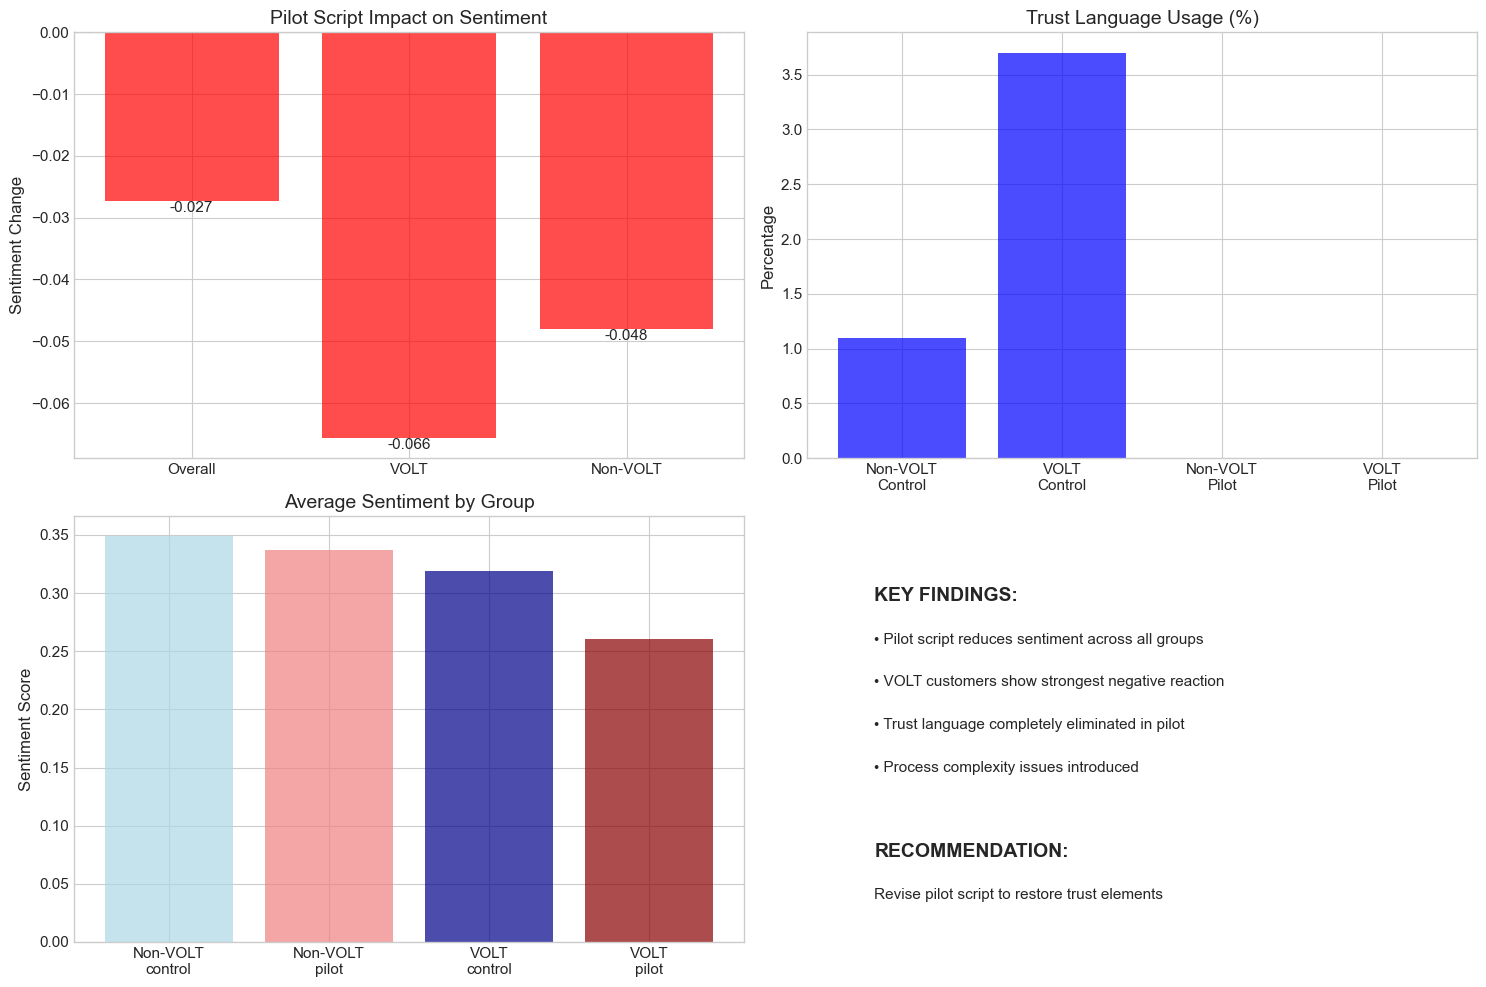


Creating word cloud comparisons...
Saved: ../outputs/figures/word_clouds_by_segment.png


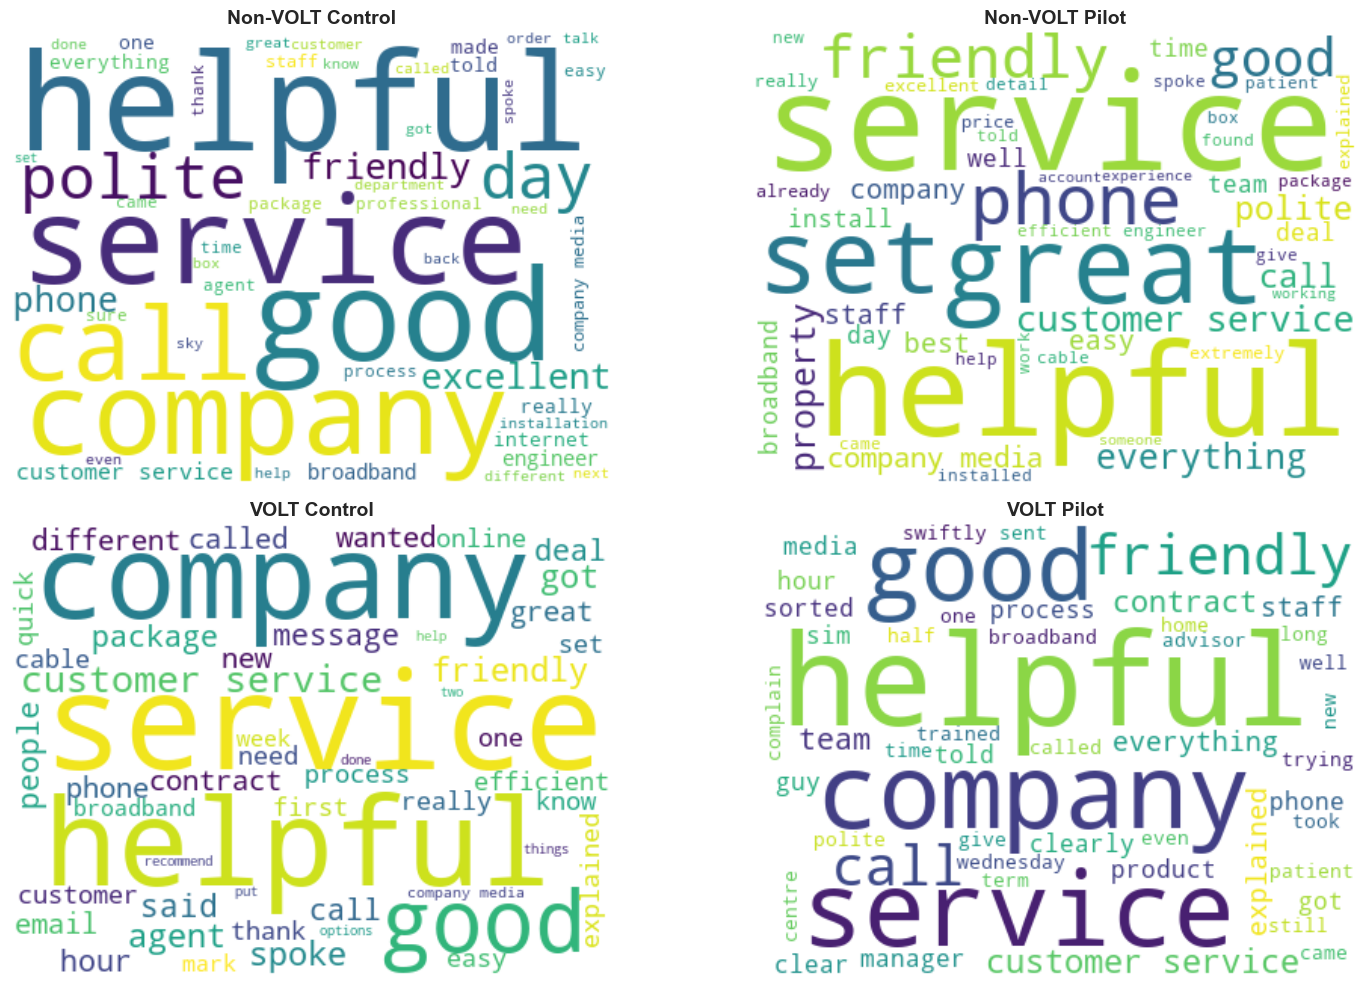

All figures saved to outputs/figures/


In [18]:
# Create executive summary visualizations
print("Creating executive summary charts...")
create_executive_summary_visualizations()

print("\nCreating word cloud comparisons...")
create_word_clouds_by_segment()

print("All figures saved to outputs/figures/")

## Limitations 

* **Sample Size:** Small dataset (422 comments) limits statistical power. Consequently, results may not apply to broader customer base.

* **Response Bias**: Only customers who chose to comment are included, missing out on a lot of potential responses

* **Temporal Effects**: February exclusion may have removed seasonal patterns

* **Segment Imbalance**: VOLT pilot group much smaller (36 vs 81 control)

* **Text Quality**: Short comments limit depth of sentiment analysis

* **Selection Bias**: Unknown factors influencing who provides feedback

* Pilot script effects might vary by agent implementation



## Ethical Considerations

* Avoid manipulative language designed to pressure decisions

* Focus on clarity and trust-building, not persuasion tactics

* Customer comments used for business improvement, not individual profiling

* Aggregated analysis protects individual privacy

* Maintain transparency about script changes

* Regular monitoring to ensure positive customer outcomes

* Aggregated analysis protects individual privacy

# Final Recommendations

1. **Restore Trust-building Language**

    * **Problem:** 0% trust language in pilot vs 1.1-3.7% in control

    * **Solution:**
        * Add phrases like 'I want to make sure you're comfortable'
        * Include 'You can trust that we'll...' statements
        * Use 'reliable' and 'secure' when discussing services

<br>

2. **Streamline Process for VOLT Customers**

    * **Problem:** VOLT customers show 'took hours' complaints

    * **Solution:**
        * Create expedited process for premium customers
        * Reduce handoffs and team coordination issues
        * Add time expectations upfront

<br>

3. **Enhance Agent Communication Training**

    * **Problem:** 'Helpful' appears in negative comments

    * **Solution:**
        * Train agents on helpfulness
        * Focus on solution-oriented language
        * Avoid scripted responses that sound insincere

<br>

4. **Address Phone/Call Management**

    * **Problem:** Phone/call issues emerge in pilot negative comments

    * **Solution:**
        * Improve call handling procedures
        * Reduce wait times and transfers
        * Clear communication about next steps